# Detector de Texto para OCR
Este modelo pretende detectar la resencia de texto en una imagen y en lo posible retornar las lineas de texto y cajas de los carcteres que las componen.

Modelo basado en yolo 8

## Importación de Librerias

In [10]:
#Importo librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import re
import cv2
import random
from PIL import Image, ImageFilter, ImageDraw, ImageFont
from IPython.display import Image as ImageDisplay
from IPython.core.display import HTML
from io import BytesIO
import base64

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Variables de configuracion
archivo_zip_fuentes = '/content/drive/MyDrive/tp_integrador/fuentes.zip'
carpeta_destino = '/content/fuentes'
cantidad_de_repeticiones = 2 # Cantidad de repeticiones por letra y fuente
largo_minimo_palabra = 1 # cantidad minima de caracteres por palabra
largo_maximo_palabra = 4 # cantidad maxima de caracteres por palabra
maximo_palabras_imagen = 3 # cantidad maxima de palabras por imagen * 1 palabra por linea
carpeta_destino_datasets = '/content/datasets'
rango_separacion_caracteres = (1,5)
rango_separacion_lineas = (10,40)
rango_tamanio_fuente = (24,48)
tamanio_imagen = 256 #imagenes cuadradas
characters_to_generate = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789" # Caracteres del diccionario

## Generacion del dataset de fuentes y palabras

In [4]:
#Descomprimo las fuentes

!unzip {archivo_zip_fuentes} -d {carpeta_destino}

Archive:  /content/drive/MyDrive/tp_integrador/fuentes.zip
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Nag_Mundari/Noto_Sans_Nag_Mundari-700.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Mayan_Numerals/Noto_Sans_Mayan_Numerals-regular.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Oriya/Noto_Sans_Oriya-600.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_NKo_Unjoined/Noto_Sans_NKo_Unjoined-regular.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Meetei_Mayek/Noto_Sans_Meetei_Mayek-800.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Meetei_Mayek/Noto_Sans_Meetei_Mayek-700.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Meetei_Mayek/Noto_Sans_Meetei_Mayek-500.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_NKo_Unjoined/Noto_Sans_NKo_Unjoined-700.ttf  
  inflating: /content/fuentes/ocr_fonts_latin/Noto_Sans_Nag_Mundari/Noto_Sans_Nag_Mundari-regular.ttf  
  inflating: /content/fue

In [12]:
#Creo un dataset con las fuentes
def create_font_dataset(base_folder):
    """
    Crea un DataFrame de Pandas con información sobre las fuentes TTF encontradas.

    Args:
        base_folder (str): Ruta a la carpeta principal que contiene las subcarpetas de tipos de letra.

    Returns:
        pd.DataFrame: DataFrame con columnas 'font_name' y 'font_path'.
    """
    font_data = []
    print(f"Buscando archivos .ttf en: {base_folder}")
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            # Comprobamos si el archivo termina con '.ttf' o '.otf' (sin importar mayúsculas/minúsculas)
            if file.lower().endswith(('.ttf', '.otf')):
                # Si es una fuente, añadimos la ruta completa a la lista
                full_font_path = os.path.join(root, file)
                full_font_path = full_font_path.replace('\\', '/').replace('//','/')
                font_file_name = file
                font_name = os.path.splitext(font_file_name)[0]
                font_data.append({
                    'font_name': font_name, # Usamos el nombre de la carpeta como nombre de la fuente
                    'font_path': full_font_path
                })

    return pd.DataFrame(font_data)

In [13]:
font_df = create_font_dataset(carpeta_destino)
font_df.info()

Buscando archivos .ttf en: /content/fuentes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   font_name  3921 non-null   object
 1   font_path  3921 non-null   object
dtypes: object(2)
memory usage: 61.4+ KB


In [14]:
def generate_palabras(char_list_original, min_len=2, max_len=4):

    # 1. Convertir la cadena original a una lista y desordenarla una única vez
    shuffled_char_pool = list(char_list_original)
    random.shuffle(shuffled_char_pool)

    generated_combinations = []

    pool_index = 0
    total_pool_len = len(shuffled_char_pool)

    while pool_index < total_pool_len:
        # Calcular cuántos caracteres quedan en el pool
        remaining_chars = total_pool_len - pool_index

        # Determinar la longitud de la combinación actual
        # Si quedan 7 o menos caracteres (o menos de max_len) y al menos min_len, usa todos los restantes.
        # De lo contrario, elige una longitud aleatoria entre min_len y max_len.
        if remaining_chars <= max_len:
            current_len = remaining_chars
        else:
            current_len = random.randint(min_len, max_len)
            # Asegurarse de que la longitud elegida no exceda los caracteres restantes
            current_len = min(current_len, remaining_chars)

        # Extraer la combinación del pool
        combination_chars = shuffled_char_pool[pool_index : pool_index + current_len]
        combination = "".join(combination_chars)

        generated_combinations.append(combination)
        pool_index += current_len # Mover el índice al siguiente punto en el pool

    print(f"Número de palabras generadas: {len(generated_combinations)}")
    return generated_combinations

In [15]:
palabras_a_generar = []
if not font_df.empty:
    for index, font_row in font_df.iterrows():
        font_name = font_row['font_name']
        font_path = font_row['font_path']
        print(f"Generando caracteres para la fuente: {font_name} ({font_path})")
        for i in range(cantidad_de_repeticiones):
            lista_actual = generate_palabras(characters_to_generate, largo_minimo_palabra, largo_maximo_palabra)
            for palabra in lista_actual:
                palabras_a_generar.append({'palabra':palabra,'font_name':font_name,'font_path':font_path})

random.shuffle(palabras_a_generar)
palabras_a_generar = pd.DataFrame(palabras_a_generar)
print(f"Total de palabras a generar: {len(palabras_a_generar)}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Número de palabras generadas: 23
Generando caracteres para la fuente: Gabarito-600 (/content/fuentes/ocr_fonts_latin/Gabarito/Gabarito-600.ttf)
Número de palabras generadas: 25
Número de palabras generadas: 22
Generando caracteres para la fuente: Gabarito-regular (/content/fuentes/ocr_fonts_latin/Gabarito/Gabarito-regular.ttf)
Número de palabras generadas: 25
Número de palabras generadas: 21
Generando caracteres para la fuente: Gabarito-700 (/content/fuentes/ocr_fonts_latin/Gabarito/Gabarito-700.ttf)
Número de palabras generadas: 23
Número de palabras generadas: 21
Generando caracteres para la fuente: Barlow_Semi_Condensed-500 (/content/fuentes/ocr_fonts_latin/Barlow_Semi_Condensed/Barlow_Semi_Condensed-500.ttf)
Número de palabras generadas: 24
Número de palabras generadas: 22
Generando caracteres para la fuente: Barlow_Semi_Condensed-600 (/content/fuentes/ocr_fonts_latin/Barlow_Semi_Condensed/Barlow_Semi_Condensed-600.

## Generacion de las imagenes con las palabras

In [16]:
# prompt: quiero una funcion que reciba una imagen de cv en escala de grises y le aplique blur gausieano y la devuelva en el mismo formato

def apply_gaussian_blur(image_gray, ksize=(3, 3), sigmaX=0):
    """
    Aplica un filtro de desenfoque Gaussiano a una imagen en escala de grises.

    Args:
        image_gray (np.ndarray): Imagen de entrada en escala de grises (array NumPy).
        ksize (tuple): Tamaño del kernel Gaussiano. Debe ser una tupla de números
                       enteros impares positivos (ancho, alto).
        sigmaX (float): Desviación estándar del kernel en la dirección X. Si es 0,
                        se calcula automáticamente en función del tamaño del kernel.

    Returns:
        np.ndarray: La imagen desenfocada como un array NumPy en escala de grises.
    """
    if len(image_gray.shape) != 2:
        print("Advertencia: La imagen de entrada no está en escala de grises. Intentando convertir.")
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.GaussianBlur(image_gray, ksize, sigmaX)
    return blurred_image

def invert_image(image):
    """
    Invierte la imagen en escala de grises.
    """
    return 255 - image


In [17]:
def obtener_dimensiones_contorno_caracter(caracter:str, ruta_fuente:str, tamano_fuente:int):

    # Dimensiones de la imagen base (suficientemente grande para cualquier caracter)
    img_width, img_height = tamano_fuente * 2, tamano_fuente * 2

    # Crear una imagen en blanco con fondo negro
    img = Image.new('L', (img_width, img_height), color=0) # 'L' para escala de grises
    d = ImageDraw.Draw(img)

    font = ImageFont.truetype(ruta_fuente, tamano_fuente)

    # Calcular el tamaño del texto para centrarlo
    bbox = d.textbbox((0,0), caracter, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Calcular la posición para centrar el texto
    x = (img_width - text_width) // 2
    y = (img_height - text_height) // 2

    # Dibujar el caracter en blanco sobre fondo negro
    d.text((x, y), caracter, font=font, fill=255)

    # Convertir la imagen de Pillow a un array de NumPy para OpenCV
    img_np = np.array(img)

    # Encontrar contornos
    contours, _ = cv2.findContours(img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, 0  # No se encontraron contornos

    all_points = np.vstack(contours)
    # Encontrar el rectángulo delimitador para el contorno combinado
    x, y, w, h = cv2.boundingRect(all_points)
    return x, y, w, h


In [29]:
import math
def generar_imagen_multifuente(palabras_fuentes, palabras_a_generar, tamanio_imagen, rango_separacion_caracteres, rango_separacion_lineas, rango_tamanio_fuente, output_path=None):

    # Configuración base
    img_size = tamanio_imagen
    margen = 10 #Ajustar a gusto
    fuentes_erroneas=[]

    # Seleccionar parámetros comunes para toda la imagen
    tamano_fuente = random.randint(*rango_tamanio_fuente)
    separacion_lineas = random.randint(*rango_separacion_lineas)
    espaciado_caracteres = random.randint(*rango_separacion_caracteres)

    # Crear imagen PIL (fondo negro)
    img_pil = Image.new('L', (img_size, img_size), color=0)
    draw = ImageDraw.Draw(img_pil)

    # Listas para resultados
    bboxes = []
    caracteres = []

    # Pre-calcular altura total
    alto_total = len(palabras_fuentes) * tamano_fuente + (len(palabras_fuentes) - 1) * separacion_lineas
    y_actual = (img_size - alto_total) // 2

    # Procesar cada palabra con su fuente
    for idx, row in palabras_fuentes.iterrows():
        palabra = row['palabra']
        fuente = row['font_name']
        ruta_fuente = row['font_path']
        try:
            font = ImageFont.truetype(ruta_fuente, tamano_fuente)
        except Exception as e:
            fuentes_erroneas.append(ruta_fuente)
            print(f"Error cargando fuente {ruta_fuente}: {str(e)}")
            continue
        # Calcular ancho de la palabra con espaciado
        try:
            ancho_palabra = sum(draw.textlength(c, font=font) + espaciado_caracteres for c in palabra) - espaciado_caracteres
        except:
            print(f"error calculando el ancho para la fuente {fuente}")
            fuentes_erroneas.append(ruta_fuente)
            continue
        # Si la palabra excede el ancho permitido ajusto los valores a los minimos
        if ancho_palabra <= img_size - margen*2:
            tamano_fuente = rango_tamanio_fuente[0]
            espaciado_caracteres = rango_separacion_caracteres[0]
            font = ImageFont.truetype(ruta_fuente, tamano_fuente)
            ancho_palabra = sum(draw.textlength(c, font=font) + espaciado_caracteres for c in palabra) - espaciado_caracteres

        # Posición horizontal (centrado)
        x_actual = (img_size - ancho_palabra) // 2

        # Procesar cada caracter
        for caracter in palabra:
            try:
                # Calcular bbox
                left, top, right, bottom = font.getbbox(caracter)
                ancho_car = draw.textlength(caracter, font=font)
                ancho_car = int(math.ceil(ancho_car))
                _, _, ancho_real, _ = obtener_dimensiones_contorno_caracter(caracter, ruta_fuente, tamano_fuente)
                x_caja = x_actual - abs(max(ancho_real,right,ancho_car) - min(ancho_real,right,ancho_car))
                bbox = [
                    int(max(x_caja,1)),
                    int(y_actual + top),
                    int(x_actual + max(ancho_real, ancho_car, right)),
                    int(y_actual + bottom)
                ]
                if x_caja <= 0 or x_actual + max(ancho_real, ancho_car, right) >= (img_size - 20):
                    print(f"palabra exedida del ancho: {palabra} - fuente: {fuente}")
                bboxes.append(bbox)
                caracteres.append(caracter)

                # Dibujar caracter
                draw.text(
                    (x_actual, y_actual),
                    caracter,
                    font=font,
                    fill=255
                )

                # Mover posición horizontal
                x_actual += max(ancho_real, ancho_car, right) + espaciado_caracteres
            except:
                print(f"no se pudo procesar el cacarcter '{caracter}' para la fuente {fuente}")
                fuentes_erroneas.append(ruta_fuente)

        # Mover posición vertical
        y_actual += tamano_fuente + separacion_lineas

    # Convertir a OpenCV
    img_cv2 = np.array(img_pil)

    #aplico blur al 20%
    if random.random() < 0.2:
        img_cv2 = apply_gaussian_blur(img_cv2)

    #invierto colores al 20%
    if random.random() < 0.2:
        img_cv2 = invert_image(img_cv2)

    #Si se definio carpeta de salida guarda la imagen
    if output_path:
        cv2.imwrite(output_path, img_cv2)

    #- Opcional: Elimina las fuentes con errores o que no reconocen todo el diccionario
    if fuentes_erroneas:
        for fuente in fuentes_erroneas:
            try:
                #path_corregido = fuente.replace('/', '\\') para windows
                path_corregido = fuente.replace('\\', '/') #para linux o colab
                os.remove(path_corregido)
                print(f"fuente {path_corregido} eliminada")
            except: # si no funciona pruebo por linea de comandos
                try:
                    #!del /f /q "{path_corregido}" #para windows
                    !rm -f "{path_corregido}" #para linux o colab
                    print(f"fuente {path_corregido} eliminada")
                except:
                    print(f"no se pudo eliminar la fuente {path_corregido}")
            palabras_a_generar = palabras_a_generar[palabras_a_generar['font_path'] != fuente]

    return img_cv2, bboxes, caracteres, palabras_a_generar

In [30]:
info_imagenes = []
data_imagenes = []
index_imagen = 0
palabras_generadas = 0
index_actual = 0

print(f"Total de palabras a generar: {len(palabras_a_generar)}")
if len(palabras_a_generar) > 0:
    while index_actual < len(palabras_a_generar):
        if index_actual % 1000 == 0:
            print(f"{index_actual * 100 // len(palabras_a_generar)}% completado.")
        cantidad_actual = random.randint(1, maximo_palabras_imagen)
        cantidad_actual = min(cantidad_actual, len(palabras_a_generar) - index_actual)
        palabras_actuales = palabras_a_generar.iloc[index_actual : index_actual + cantidad_actual]
        fuentes_actuales = ''
        for idx, row in palabras_actuales.iterrows():
            fuentes_actuales += f"{row['font_name']}"
            if idx < len(palabras_actuales) - 1:
                fuentes_actuales += ', '
        img_cv2, bboxes, caracteres, palabras_a_generar = generar_imagen_multifuente(palabras_actuales, palabras_a_generar, tamanio_imagen, rango_separacion_caracteres, rango_separacion_lineas, rango_tamanio_fuente)
        info_imagenes.append({'labels':caracteres,'fuentes':fuentes_actuales,'index':index_imagen})
        data_imagenes.append({'imagen':img_cv2,'bboxes':bboxes,'index':index_imagen})
        index_actual += cantidad_actual
        index_imagen += 1
    print(f"total: {index_imagen} imagenes generadas")

Total de palabras a generar: 192983
0% completado.
0% completado.
0% completado.
1% completado.
2% completado.
2% completado.
2% completado.
3% completado.
3% completado.
4% completado.
5% completado.
5% completado.
5% completado.
6% completado.
6% completado.
6% completado.
7% completado.
7% completado.
7% completado.
8% completado.
8% completado.
10% completado.
10% completado.
10% completado.
10% completado.
11% completado.
11% completado.
11% completado.
12% completado.
12% completado.
12% completado.
12% completado.
13% completado.
14% completado.
14% completado.
15% completado.
15% completado.
16% completado.
16% completado.
16% completado.
17% completado.
17% completado.
18% completado.
18% completado.
18% completado.
19% completado.
19% completado.
19% completado.
20% completado.
21% completado.
palabra exedida del ancho: zPJD - fuente: Asset-regular
palabra exedida del ancho: zPJD - fuente: Asset-regular
22% completado.
22% completado.
23% completado.
23% completado.
24% compl

Index: 70962, Letras: ['5', 'K', '0', 'c', 'k', 'W', '7', '0'], Fuente: Noto_Kufi_Arabic-500Magra-regularNoto_Sans_Ol_Chiki-regular


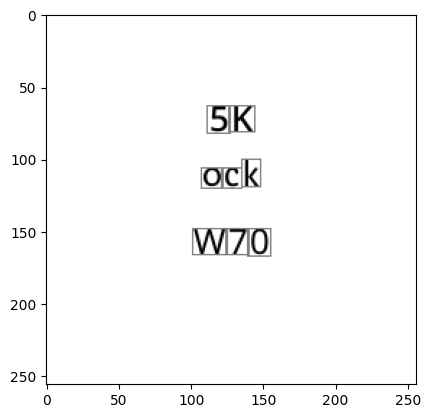



Index: 59744, Letras: ['u', 's', 'z', 'V', 'q', 'w', 'z'], Fuente: Edu_VIC_WA_NT_Hand-700Khula-300Mitr-300


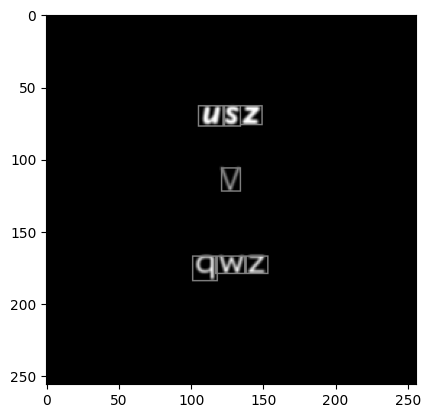



Index: 6241, Letras: ['Q'], Fuente: Kodchasan-500italic


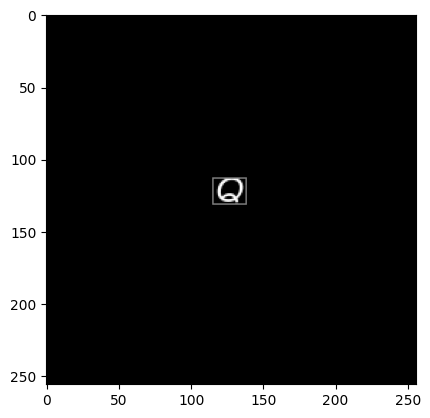



Index: 85046, Letras: ['t', 'K'], Fuente: Akatab-900Crushed-regular


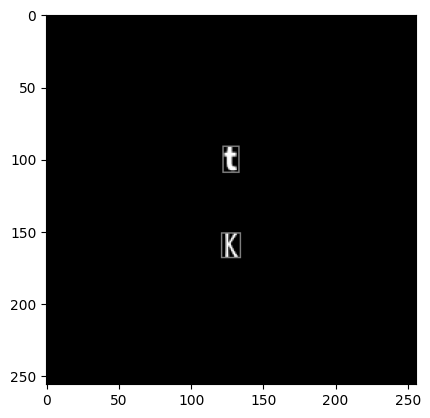



Index: 62258, Letras: ['c'], Fuente: Kalnia_Glaze-500


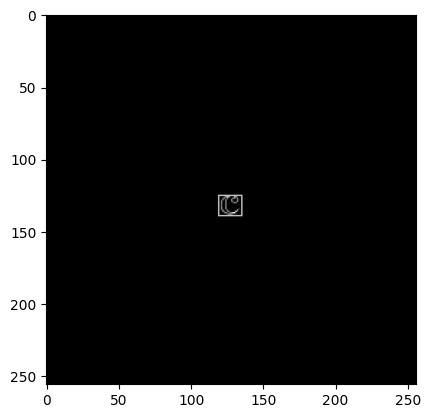



Index: 71567, Letras: ['a', 'g', 'G', 'u', 'K'], Fuente: Akatab-700Barlow_Semi_Condensed-300italic


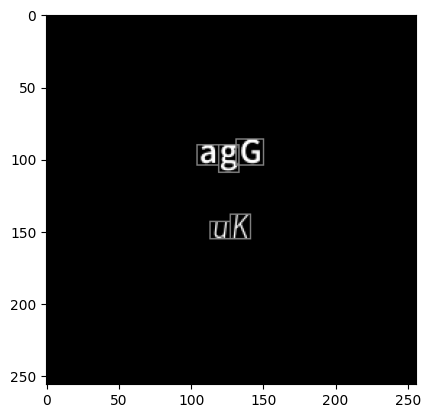



Index: 91637, Letras: ['I', 'D', 'b', 'N'], Fuente: Anek_Devanagari-800


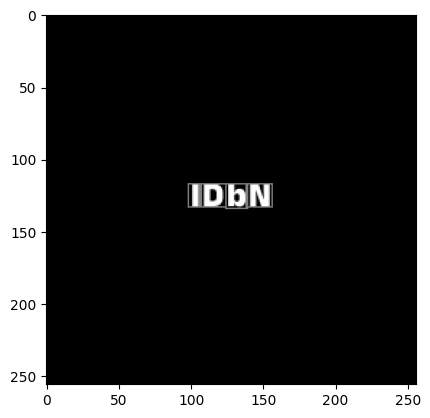



Index: 40818, Letras: ['S', 'P', 'a', 'b', 'D', 'J'], Fuente: Alumni_Sans_Inline_One-regularMontserrat_Alternates-900


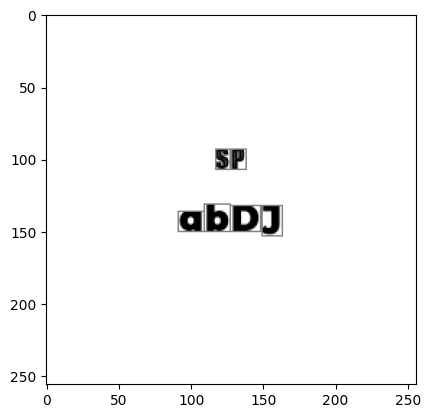



Index: 42973, Letras: ['J', 'S', 'i', '0', 'c', 'v', 'u'], Fuente: Familjen_Grotesk-500italicAsap-800italic


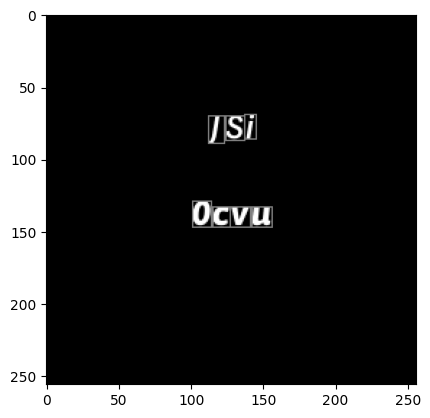



Index: 50920, Letras: ['i', 'Y', '4', 'C', 's', 'F'], Fuente: Julius_Sans_One-regularNobile-700


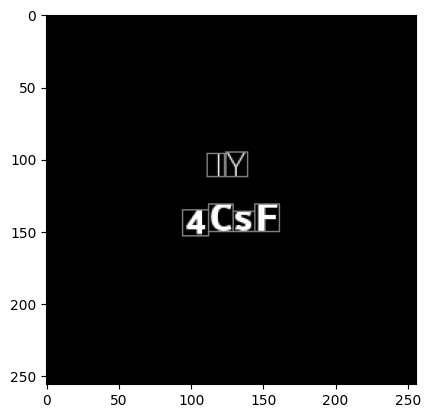



Index: 43389, Letras: ['o', 'F'], Fuente: Anek_Bangla-800


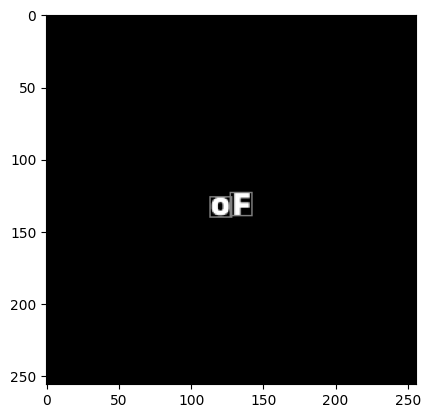



Index: 19444, Letras: ['h', 'g', '5', 'Q'], Fuente: Blaka_Ink-regular


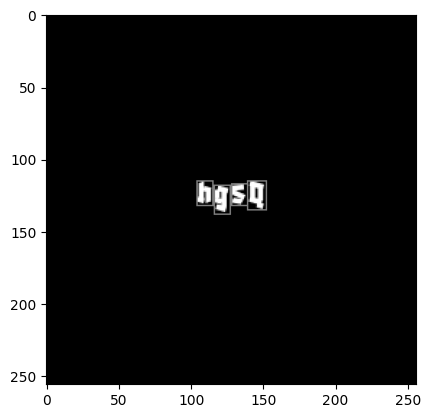



Index: 75171, Letras: ['V', 'J', '3', 'H', 'P', 'X', '5', 'C', 'M', 'r', 'I'], Fuente: Fascinate_Inline-regularNoto_Sans_Cham-regularEncode_Sans_Semi_Condensed-900


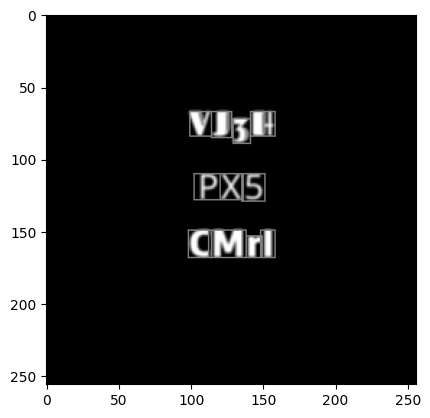



Index: 26973, Letras: ['z', 'V', 'U', 'c'], Fuente: Merriweather-600italicMerriweather_Sans-300italic


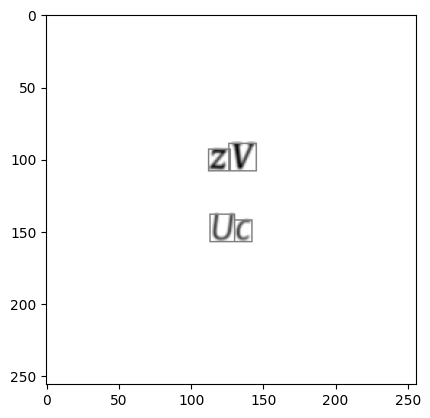



Index: 47090, Letras: ['V', 'g'], Fuente: Foldit-700


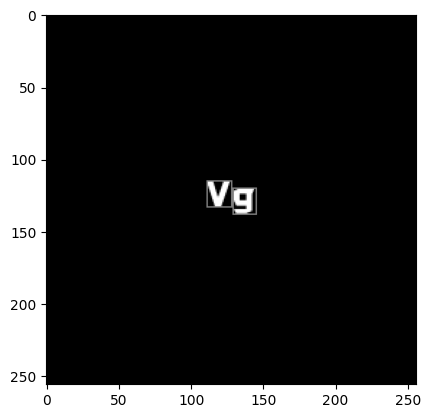



Index: 51304, Letras: ['p', 'b', '9', 'q', 'r'], Fuente: Amiko-regularIBM_Plex_Sans-300italic


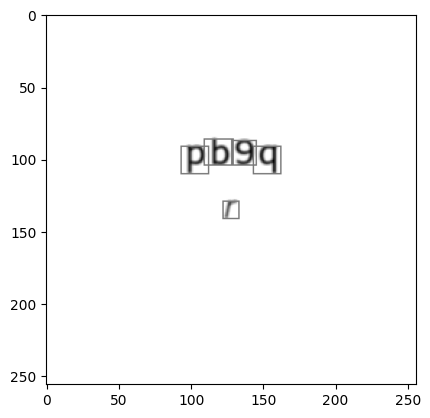



Index: 52309, Letras: ['D', 'U', 'B', 'A', 'Q'], Fuente: Alegreya_SC-900Lunasima-700


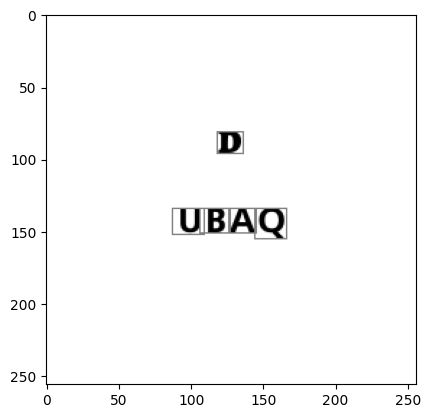



Index: 15629, Letras: ['E', 'j', 'r', '7'], Fuente: Kanit-900Noto_Sans_Manichaean-regularDM_Sans-500


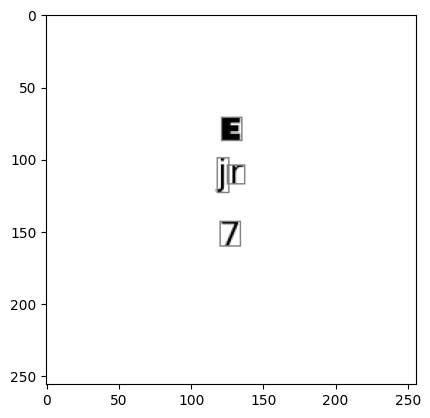



Index: 79750, Letras: ['I', 'Z', 'r', 'Q', '0', 'R'], Fuente: Bitter-900Comme-100Lexend_Mega-500


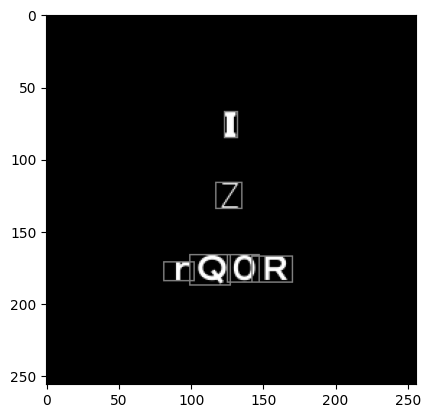



Index: 39187, Letras: ['v', '5', 'o', 'l'], Fuente: Cormorant_Infant-regularEpilogue-100


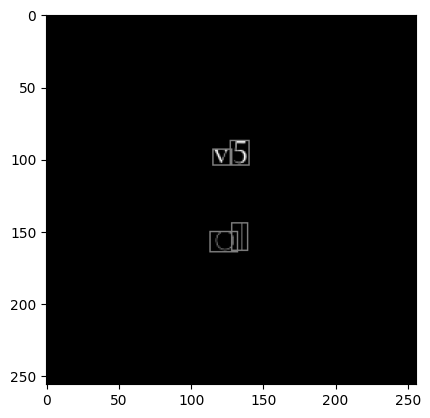

In [31]:
pandas_dataset = pd.DataFrame(info_imagenes)
numpy_dataset = np.array(data_imagenes)
muestra = pandas_dataset.sample(20)
for index, row in muestra.iterrows():
    print(f"Index: {row['index']}, Letras: {row['labels']}, Fuente: {row['fuentes']}")
    img_muestra = numpy_dataset[row['index']]['imagen']
    bboxes= numpy_dataset[row['index']]['bboxes']
    for bbox in bboxes:
        cv2.rectangle(img_muestra, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (128, 128, 128), 1)
    plt.imshow(img_muestra, cmap='gray')
    plt.show()
    print("\n")

In [32]:
# Crear el directorio si no existe
os.makedirs(carpeta_destino_datasets, exist_ok=True)

# Guardar el dataset de imágenes (arrays numpy) como archivo .npy
numpy_output_path = os.path.join(carpeta_destino_datasets, 'imagenes_dataset.npy')
np.save(numpy_output_path, numpy_dataset)
print(f"Dataset de imágenes guardado en: {numpy_output_path}")

# Guardar el dataset de información (pandas DataFrame) como archivo .csv
pandas_output_path = os.path.join(carpeta_destino_datasets, 'info_imagenes.csv')
pandas_dataset.to_csv(pandas_output_path, index=False)
print(f"Dataset de información guardado en: {pandas_output_path}")

Dataset de imágenes guardado en: /content/datasets/imagenes_dataset.npy
Dataset de información guardado en: /content/datasets/info_imagenes.csv
